<a href="https://colab.research.google.com/github/vitokosasih/Coursera_Capstone/blob/master/Capstone_The_Battle_of_the_Neighborhoods_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Capstone Project - The Battle of the Neighborhoods (Week 2)
### Applied Data Science Capstone by IBM/Coursera

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)






## Introduction: Business Problem <a name="introduction"></a>

There is a cafe brand that is well known among young people in Australia who want to open their first branch in Indonesia, to be precise in Jakarta. It takes careful consideration to determine which location is the best choice for them. We will use our data science powers to generate a few most promissing neighborhoods based on this criteria. Advantages of each area will then be clearly expressed so that best possible final location can be chosen by stakeholders.

## Data <a name="data"></a>

To launch this project, the brand needs more knowledge about demographics in Jakarta, such as:

1.   How many cafes are already established in the area?
2.   What is the most popular venues?
3.   What is the total population of young people (their's target market) in the area?

Following data sources will be needed to extract/generate the required information:
1.   1st data: contains the latitude, longitude for each neighborhood in Jakarta.
2.   2nd data: https://data.jakarta.go.id/dataset/jumlah-penduduk-berdasarkan-tenaga-kerja-jenis-kelamin-dan-umur contains the total population based on age categories in each neighborhood in Jakarta.
3.   3rd data: https://developer.foursquare.com/ contains the most popular or common venues of a given neighborhood in Jakarta.

## Methodology

### Importing all required libraries!

In [1]:
!pip install geopandas

In [2]:
import pandas as pd
import requests
from bs4 import BeautifulSoup as soup
import folium
from geopy.geocoders import Nominatim
from pandas.io.json import json_normalize
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import geopandas as gpd

In [3]:
from google.colab import files
uploaded= files.upload()

Saving Indonesian_Family_Life_Survey_4_Longitude_and_Latitude.txt to Indonesian_Family_Life_Survey_4_Longitude_and_Latitude (2).txt


In [4]:
uploaded= files.upload()

Saving data-jumlah-penduduk-provinsi-dki-jakarta-berdasarkan-kelompok-usia-dan-jenis-kelamin-tahun-2020.csv to data-jumlah-penduduk-provinsi-dki-jakarta-berdasarkan-kelompok-usia-dan-jenis-kelamin-tahun-2020 (1).csv


In [5]:
df = pd.read_csv('Indonesian_Family_Life_Survey_4_Longitude_and_Latitude.txt')
age_group = pd.read_csv('data-jumlah-penduduk-provinsi-dki-jakarta-berdasarkan-kelompok-usia-dan-jenis-kelamin-tahun-2020.csv')

### Pre-processing Data

### Drop unecessary columns!

In [6]:
df.drop(columns=['province_code', 'kabupaten_code', 'kecamatan_code'], inplace= True)

In [7]:
age_group.drop(columns=['tahun', 'nama_provinsi', 'nama_kabupaten_kota', 'nama_kelurahan', 'Unnamed: 8', 'jenis_kelamin'], inplace= True)

### Get DKI Jakarta provincial data

In [8]:
df = df[df['province_name'] == 'DKI JAKARTA']

In [9]:
df.head()

,lat,lng,province_name,kabupaten_name,kecamatan_name
534,-6.334917,106.823737,DKI JAKARTA,JAKARTA SELATAN,JAGAKARSA
535,-6.293981,106.823737,DKI JAKARTA,JAKARTA SELATAN,PASAR MINGGU
536,-6.284528,106.800140,DKI JAKARTA,JAKARTA SELATAN,CILANDAK
537,-6.247428,106.761798,DKI JAKARTA,JAKARTA SELATAN,PESANGGRAHAN
538,-6.244392,106.776544,DKI JAKARTA,JAKARTA SELATAN,KEBAYORAN LAMA


### Remap the usia(age) column

In [10]:
a = {"00-04" : "CHILD", "05-09": "CHILD", "10-14": "CHILD", \
     "15-19": "ADULT", "20-24": "ADULT", "25-29": "ADULT", "30-34": "ADULT", "35-39": "ADULT", \
     "40-44": "MIDDLE", "45-49": "MIDDLE", "50-54": "MIDDLE", "55-59": "MIDDLE", \
     "60-64": "ELDER", "65-69": "ELDER", "70-74": "ELDER", "75+": "ELDER"}

In [11]:
age_group.usia = age_group.usia.map(a)

### Merge the population data into df

In [12]:
child = age_group[age_group['usia']=='CHILD']
child= child.groupby(['nama_kecamatan'], as_index = False)['jumlah_penduduk'].sum()
child.rename(columns={"jumlah_penduduk": "child_population"},inplace = True)
child.head()

,nama_kecamatan,child_population
0,CAKUNG,151969
1,CEMPAKA PUTIH,22418
2,CENGKARENG,149328
3,CILANDAK,51620
4,CILINCING,121877


In [13]:
adult = age_group[age_group['usia']=='ADULT']
adult= adult.groupby(['nama_kecamatan'], as_index = False)['jumlah_penduduk'].sum()
adult.rename(columns={"jumlah_penduduk": "adult_population"},inplace = True)
adult.head()

,nama_kecamatan,adult_population
0,CAKUNG,236707
1,CEMPAKA PUTIH,38744
2,CENGKARENG,237620
3,CILANDAK,87359
4,CILINCING,182346


In [14]:
elder = age_group[age_group['usia']=='ELDER']
elder= elder.groupby(['nama_kecamatan'], as_index = False)['jumlah_penduduk'].sum()
elder.rename(columns={"jumlah_penduduk": "elder_population"},inplace = True)
elder.head()

,nama_kecamatan,elder_population
0,CAKUNG,35626
1,CEMPAKA PUTIH,11099
2,CENGKARENG,37949
3,CILANDAK,20980
4,CILINCING,26305


In [15]:
total= age_group.groupby(['nama_kecamatan'], as_index = False)['jumlah_penduduk'].sum()
total.rename(columns={"jumlah_penduduk": "total_population"},inplace = True)
total.head()

,nama_kecamatan,total_population
0,CAKUNG,572996
1,CEMPAKA PUTIH,102273
2,CENGKARENG,576216
3,CILANDAK,225332
4,CILINCING,440235


In [16]:
df = df.merge(child, left_on= 'kecamatan_name', right_on= 'nama_kecamatan')
df = df.merge(adult, left_on= 'kecamatan_name', right_on= 'nama_kecamatan')
df = df.merge(elder, left_on= 'kecamatan_name', right_on= 'nama_kecamatan')
df = df.merge(total, left_on= 'kecamatan_name', right_on= 'nama_kecamatan')

In [17]:
df.head()

,lat,lng,province_name,kabupaten_name,kecamatan_name,nama_kecamatan_x,child_population,nama_kecamatan_y,adult_population,nama_kecamatan_x,elder_population,nama_kecamatan_y,total_population
0,-6.334917,106.823737,DKI JAKARTA,JAKARTA SELATAN,JAGAKARSA,JAGAKARSA,92129,JAGAKARSA,145741,JAGAKARSA,26426,JAGAKARSA,363091
1,-6.293981,106.823737,DKI JAKARTA,JAKARTA SELATAN,PASAR MINGGU,PASAR MINGGU,81159,PASAR MINGGU,131646,PASAR MINGGU,26774,PASAR MINGGU,331825
2,-6.284528,106.800140,DKI JAKARTA,JAKARTA SELATAN,CILANDAK,CILANDAK,51620,CILANDAK,87359,CILANDAK,20980,CILANDAK,225332
3,-6.247428,106.761798,DKI JAKARTA,JAKARTA SELATAN,PESANGGRAHAN,PESANGGRAHAN,65879,PESANGGRAHAN,105270,PESANGGRAHAN,21502,PESANGGRAHAN,264667
4,-6.244392,106.776544,DKI JAKARTA,JAKARTA SELATAN,KEBAYORAN LAMA,KEBAYORAN LAMA,78496,KEBAYORAN LAMA,127936,KEBAYORAN LAMA,29058,KEBAYORAN LAMA,329442


In [18]:
df = df.drop(columns=['province_name'])
df.head()

,lat,lng,kabupaten_name,kecamatan_name,nama_kecamatan_x,child_population,nama_kecamatan_y,adult_population,nama_kecamatan_x,elder_population,nama_kecamatan_y,total_population
0,-6.334917,106.823737,JAKARTA SELATAN,JAGAKARSA,JAGAKARSA,92129,JAGAKARSA,145741,JAGAKARSA,26426,JAGAKARSA,363091
1,-6.293981,106.823737,JAKARTA SELATAN,PASAR MINGGU,PASAR MINGGU,81159,PASAR MINGGU,131646,PASAR MINGGU,26774,PASAR MINGGU,331825
2,-6.284528,106.800140,JAKARTA SELATAN,CILANDAK,CILANDAK,51620,CILANDAK,87359,CILANDAK,20980,CILANDAK,225332
3,-6.247428,106.761798,JAKARTA SELATAN,PESANGGRAHAN,PESANGGRAHAN,65879,PESANGGRAHAN,105270,PESANGGRAHAN,21502,PESANGGRAHAN,264667
4,-6.244392,106.776544,JAKARTA SELATAN,KEBAYORAN LAMA,KEBAYORAN LAMA,78496,KEBAYORAN LAMA,127936,KEBAYORAN LAMA,29058,KEBAYORAN LAMA,329442


### Rename columns name into English

In [19]:
df.rename(columns={"kabupaten_name": "borough", "kecamatan_name": "neighborhood"},inplace = True)
df.head()

,lat,lng,borough,neighborhood,nama_kecamatan_x,child_population,nama_kecamatan_y,adult_population,nama_kecamatan_x,elder_population,nama_kecamatan_y,total_population
0,-6.334917,106.823737,JAKARTA SELATAN,JAGAKARSA,JAGAKARSA,92129,JAGAKARSA,145741,JAGAKARSA,26426,JAGAKARSA,363091
1,-6.293981,106.823737,JAKARTA SELATAN,PASAR MINGGU,PASAR MINGGU,81159,PASAR MINGGU,131646,PASAR MINGGU,26774,PASAR MINGGU,331825
2,-6.284528,106.800140,JAKARTA SELATAN,CILANDAK,CILANDAK,51620,CILANDAK,87359,CILANDAK,20980,CILANDAK,225332
3,-6.247428,106.761798,JAKARTA SELATAN,PESANGGRAHAN,PESANGGRAHAN,65879,PESANGGRAHAN,105270,PESANGGRAHAN,21502,PESANGGRAHAN,264667
4,-6.244392,106.776544,JAKARTA SELATAN,KEBAYORAN LAMA,KEBAYORAN LAMA,78496,KEBAYORAN LAMA,127936,KEBAYORAN LAMA,29058,KEBAYORAN LAMA,329442


In [20]:
df.shape

(39, 12)

## Analysis


### Exploratory Data Analysis

### Finding which borough has the most adult population.

In [21]:
px.bar(df, x='borough', y='adult_population', title="Which borough has most adult population.")

### Finding which neighborhood has the most adult population.

In [22]:
sorted_pop = df.sort_values(['total_population'], ascending= False)
px.bar(sorted_pop, x='neighborhood', y='total_population', barmode= 'group', title="Which Neighborhood has most adult population.")

### Finding which neighborhood has the most adult population in each borough.

In [23]:
px.bar(df, x='neighborhood', y='adult_population', color='borough', barmode= 'group', title="Which Neighborhood has most adult population.")

In [24]:
address = 'Jakarta, ID'

geolocator = Nominatim(user_agent="jakarta_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Jakarta are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Jakarta are -6.1753942, 106.827183.


In [25]:
# create map of Jakarta using latitude and longitude values
map_jakarta = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(df['lat'], df['lng'], df['neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_jakarta)  
    
map_jakarta

In [26]:
CLIENT_ID = 'GMBMVQLQ2ZF5LHDM3BJRUYU2Y4MMXUBG0H2K5PFTWMNPI4JT' # your Foursquare ID
CLIENT_SECRET = 'YLIIEV2URI1XCUSRVKQA1TRIBK1HSDU0CNDQCPYUHCXETWIQ' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: GMBMVQLQ2ZF5LHDM3BJRUYU2Y4MMXUBG0H2K5PFTWMNPI4JT
CLIENT_SECRET:YLIIEV2URI1XCUSRVKQA1TRIBK1HSDU0CNDQCPYUHCXETWIQ


In [27]:
neighborhood_latitude = df.iloc[0]['lat'] # neighborhood latitude value
neighborhood_longitude = df.iloc[0]['lng'] # neighborhood longitude value

neighborhood_name = df.iloc[0]['neighborhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of JAGAKARSA are -6.334917, 106.82373740000001.


In [28]:
Limit = 1000
radius = 1500

url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)
url # display URL

'https://api.foursquare.com/v2/venues/explore?&client_id=GMBMVQLQ2ZF5LHDM3BJRUYU2Y4MMXUBG0H2K5PFTWMNPI4JT&client_secret=YLIIEV2URI1XCUSRVKQA1TRIBK1HSDU0CNDQCPYUHCXETWIQ&v=20180605&ll=-6.334917,106.82373740000001&radius=1500&limit=100'

In [29]:
results = requests.get(url).json()

In [30]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [31]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning:

pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead



,name,categories,lat,lng
0,Kedai H.Asari,Indonesian Restaurant,-6.334400,106.827756
1,Angkringan Soember Oerip (Mas Djoko),Indonesian Restaurant,-6.333664,106.833147
2,Jag's Kitchen,Café,-6.326932,106.814657
3,Pusat Jajanan [Perempatan Ubin],Food Court,-6.330786,106.829112
4,"Sate Taichan ""Ipan"", Senayan",Food Truck,-6.334330,106.835177


In [32]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

36 venues were returned by Foursquare.


In [33]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [34]:
jakarta_venues = getNearbyVenues(df['neighborhood'], df['lat'], df['lng'])

JAGAKARSA
PASAR MINGGU
CILANDAK
PESANGGRAHAN
KEBAYORAN LAMA
KEBAYORAN BARU
MAMPANG PRAPATAN
PANCORAN
TEBET
SETIA BUDI
PASAR REBO
CIRACAS
CIPAYUNG
MAKASAR
JATINEGARA
DUREN SAWIT
CAKUNG
PULO GADUNG
MATRAMAN
TANAH ABANG
MENTENG
JOHAR BARU
CEMPAKA PUTIH
KEMAYORAN
SAWAH BESAR
GAMBIR
KEMBANGAN
KEBON JERUK
GROGOL PETAMBURAN
TAMBORA
TAMAN SARI
CENGKARENG
KALI DERES
PENJARINGAN
PADEMANGAN
TANJUNG PRIOK
KOJA
KELAPA GADING
CILINCING


In [35]:
print(jakarta_venues.shape)

(421, 7)


### See how many categories are present.

In [36]:
print('There are {} uniques categories.'.format(len(jakarta_venues['Venue Category'].unique())))

There are 118 uniques categories.


### Number of each categories.

In [37]:
jakarta_venues.groupby('Venue Category').count()['Neighborhood'].sort_values(ascending=False).head(25)

Venue Category
Indonesian Restaurant    30
Coffee Shop              23
Food Truck               20
Fast Food Restaurant     19
Asian Restaurant         19
Noodle House             16
Convenience Store        16
Pizza Place              16
Chinese Restaurant       15
Hotel                    13
Japanese Restaurant      12
Café                     12
Food Court                8
BBQ Joint                 7
Seafood Restaurant        7
Pet Store                 6
Korean Restaurant         6
Park                      6
Restaurant                6
Department Store          5
Supermarket               5
Dessert Shop              5
Bookstore                 4
Fried Chicken Joint       4
Electronics Store         4
Name: Neighborhood, dtype: int64

### Count how many venues each neighborhood has.

In [38]:
individual_jakarta_venue_count = jakarta_venues.groupby(['Neighborhood'])['Venue'].count().to_frame()
individual_jakarta_venue_count

,Venue
Neighborhood,
CAKUNG,6
CEMPAKA PUTIH,10
CENGKARENG,5
CILANDAK,5
CILINCING,1
CIPAYUNG,2
CIRACAS,1
DUREN SAWIT,5
GAMBIR,9


### Analyze Each Neighborhood

In [39]:
# one hot encoding
jakarta_onehot = pd.get_dummies(jakarta_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
jakarta_onehot['Neighborhood'] = jakarta_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [jakarta_onehot.columns[-1]] + list(jakarta_onehot.columns[:-1])
jakarta_onehot = jakarta_onehot[fixed_columns]

jakarta_onehot.head()

,Neighborhood,Acehnese Restaurant,African Restaurant,Airport Terminal,American Restaurant,Arcade,Arts & Crafts Store,Asian Restaurant,Australian Restaurant,BBQ Joint,Bagel Shop,Bakery,Balinese Restaurant,Bar,Basketball Stadium,Betawinese Restaurant,Boarding House,Bookstore,Boutique,Breakfast Spot,Bubble Tea Shop,Building,Burger Joint,Bus Line,Cafeteria,Café,Camera Store,Campground,Chinese Restaurant,Clothing Store,Coffee Shop,Concert Hall,Convenience Store,Cosmetics Shop,Cupcake Shop,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,...,Museum,Music Venue,Nightclub,Noodle House,Optical Shop,Other Great Outdoors,Palace,Park,Pet Store,Pharmacy,Pizza Place,Pool,Pub,Ramen Restaurant,Residential Building (Apartment / Condo),Restaurant,River,Salad Place,Salon / Barbershop,Seafood Restaurant,Shopping Mall,Snack Place,Soccer Field,Soccer Stadium,Soup Place,Spa,Sports Bar,Stadium,Steakhouse,Street Food Gathering,Sundanese Restaurant,Supermarket,Sushi Restaurant,Tennis Stadium,Thai Restaurant,Train Station,University,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wine Bar
0,JAGAKARSA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,JAGAKARSA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,JAGAKARSA,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,JAGAKARSA,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,JAGAKARSA,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### Group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [40]:
jakarta_grouped = jakarta_onehot.groupby('Neighborhood').mean().reset_index()
jakarta_grouped

,Neighborhood,Acehnese Restaurant,African Restaurant,Airport Terminal,American Restaurant,Arcade,Arts & Crafts Store,Asian Restaurant,Australian Restaurant,BBQ Joint,Bagel Shop,Bakery,Balinese Restaurant,Bar,Basketball Stadium,Betawinese Restaurant,Boarding House,Bookstore,Boutique,Breakfast Spot,Bubble Tea Shop,Building,Burger Joint,Bus Line,Cafeteria,Café,Camera Store,Campground,Chinese Restaurant,Clothing Store,Coffee Shop,Concert Hall,Convenience Store,Cosmetics Shop,Cupcake Shop,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,...,Museum,Music Venue,Nightclub,Noodle House,Optical Shop,Other Great Outdoors,Palace,Park,Pet Store,Pharmacy,Pizza Place,Pool,Pub,Ramen Restaurant,Residential Building (Apartment / Condo),Restaurant,River,Salad Place,Salon / Barbershop,Seafood Restaurant,Shopping Mall,Snack Place,Soccer Field,Soccer Stadium,Soup Place,Spa,Sports Bar,Stadium,Steakhouse,Street Food Gathering,Sundanese Restaurant,Supermarket,Sushi Restaurant,Tennis Stadium,Thai Restaurant,Train Station,University,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wine Bar
0,CAKUNG,0.0,0.000000,0.0,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.166667,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.00000,0.166667,0.000000,0.0000,0.000000,0.166667,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.166667,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000
1,CEMPAKA PUTIH,0.1,0.000000,0.0,0.000000,0.000000,0.00,0.000000,0.000000,0.100000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.300000,0.100000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.00000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000
2,CENGKARENG,0.0,0.000000,0.0,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.200000,0.000000,0.000000,0.000000,...,0.000000,0.200000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.2000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.00000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000
3,CILANDAK,0.0,0.000000,0.0,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.200000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.200000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.00000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000
4,CILINCING,0.0,0.000000,0.0,0.000000,0.000000,0.00,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000

### Print each neighborhood along with the top 5 most common venues


In [41]:
num_top_venues = 5

for hood in jakarta_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = jakarta_grouped[jakarta_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----CAKUNG----
                venue  freq
0         Supermarket  0.17
1         Gas Station  0.17
2  Seafood Restaurant  0.17
3              Lounge  0.17
4      Soccer Stadium  0.17


----CEMPAKA PUTIH----
                    venue  freq
0             Pizza Place   0.3
1     Acehnese Restaurant   0.1
2               BBQ Joint   0.1
3  Furniture / Home Store   0.1
4              Food Truck   0.1


----CENGKARENG----
              venue  freq
0         Pet Store   0.2
1             Hotel   0.2
2  Department Store   0.2
3       Music Venue   0.2
4     Movie Theater   0.2


----CILANDAK----
               venue  freq
0         Food Truck   0.2
1  Convenience Store   0.2
2         Hobby Shop   0.2
3     Hardware Store   0.2
4               Café   0.2


----CILINCING----
                       venue  freq
0                  BBQ Joint   1.0
1        Acehnese Restaurant   0.0
2  Middle Eastern Restaurant   0.0
3                   Pharmacy   0.0
4                  Pet Store   0.0


----CIPAYUN

### Let's put that into a pandas dataframe

In [42]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [43]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = jakarta_grouped['Neighborhood']

for ind in np.arange(jakarta_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(jakarta_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,CAKUNG,Soccer Stadium,Gas Station,Seafood Restaurant,Lounge,Supermarket,Coffee Shop,Gastropub,Furniture / Home Store,Concert Hall,Convenience Store
1,CEMPAKA PUTIH,Pizza Place,Acehnese Restaurant,Furniture / Home Store,Middle Eastern Restaurant,Food Truck,BBQ Joint,Pool,Indonesian Meatball Place,Cosmetics Shop,Cupcake Shop
2,CENGKARENG,Hotel,Pet Store,Department Store,Music Venue,Movie Theater,Convenience Store,Cosmetics Shop,Cupcake Shop,Deli / Bodega,Dessert Shop
3,CILANDAK,Hobby Shop,Convenience Store,Hardware Store,Café,Food Truck,Wine Bar,Electronics Store,Cosmetics Shop,Cupcake Shop,Deli / Bodega
4,CILINCING,BBQ Joint,Wine Bar,Fast Food Restaurant,Convenience Store,Cosmetics Shop,Cupcake Shop,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant


### Find how many coffee shop or cafe are existed in each neighborhood

In [44]:
jakarta_cafe = jakarta_venues[jakarta_venues['Venue Category'].str.contains('Café')]
jakarta_cafe.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
16,CILANDAK,-6.284528,106.800140,Bulaf Cafe,-6.287187,106.801288,Café
120,SETIA BUDI,-6.219569,106.832587,Warunk Upnormal,-6.221717,106.832543,Café
143,SETIA BUDI,-6.219569,106.832587,Avara Lounge,-6.218136,106.835442,Café
146,SETIA BUDI,-6.219569,106.832587,Sky Garden Cafe,-6.220899,106.829033,Café
202,MENTENG,-6.194031,106.832587,Lau's Kopi Tiam,-6.197665,106.835096,Café


In [45]:
jakarta_coffee = jakarta_venues[jakarta_venues['Venue Category'].str.contains('Coffee Shop')]
jakarta_coffee.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
22,PESANGGRAHAN,-6.247428,106.761798,"Starbucks, Sency",-6.246117,106.763143,Coffee Shop
28,KEBAYORAN BARU,-6.243622,106.800140,Filosofi Kopi,-6.244444,106.799754,Coffee Shop
35,KEBAYORAN BARU,-6.243622,106.800140,Starbucks Coffee Melawai,-6.245425,106.798871,Coffee Shop
44,KEBAYORAN BARU,-6.243622,106.800140,Starbucks,-6.244927,106.797888,Coffee Shop
58,KEBAYORAN BARU,-6.243622,106.800140,JOIN Coffee Bulungan,-6.242254,106.796371,Coffee Shop


In [46]:
jakarta_coffee_cafe = jakarta_cafe.append(jakarta_coffee, ignore_index=True)

In [47]:
df_coffee_cafe = jakarta_coffee_cafe[['Neighborhood','Venue']]
df_grp = df_coffee_cafe.groupby(['Neighborhood'], as_index = False).count().sort_values(['Venue'], ascending=False) #arranging no of neighborhoods and boroughs
df_grp.rename(columns={"Venue": "Number of Cafe or Coffee Shop"},inplace = True)
df_grp

,Neighborhood,Number of Cafe or Coffee Shop
10,SETIA BUDI,13
3,KEBAYORAN BARU,5
5,KEMBANGAN,5
4,KELAPA GADING,3
0,CAKUNG,1
1,CILANDAK,1
2,JATINEGARA,1
6,KOJA,1
7,MENTENG,1
8,PENJARINGAN,1


### Locate the existed coffe shop or cafe in Jakarta.

In [48]:
map_Jakarta = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers to map
for lat, lng, venue, neighborhood in zip(jakarta_coffee_cafe['Venue Latitude'], jakarta_coffee_cafe['Venue Longitude'], jakarta_coffee_cafe['Venue'], jakarta_coffee_cafe['Neighborhood']):
    label = '{}, {}'.format(venue,neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.Marker([lat, lng]).add_to(map_Jakarta)
    folium.CircleMarker(
        [lat, lng],
        radius=10,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0,
        parse_html=False).add_to(map_Jakarta)  
    
map_Jakarta

### Cluster the Neighborhoods

In [49]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning:

The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.



In [50]:
jakarta_grouped2 = jakarta_grouped.merge(df, left_on= 'Neighborhood', right_on= 'neighborhood')
jakarta_grouped2 = jakarta_grouped2.drop(columns=['nama_kecamatan_x', 'nama_kecamatan_y'])

In [51]:
jakarta_grouped2.borough.unique()

array(['JAKARTA TIMUR', 'JAKARTA PUSAT', 'JAKARTA BARAT',
       'JAKARTA SELATAN', 'JAKARTA UTARA'], dtype=object)

In [52]:
b= {'JAKARTA UTARA' : 1, 'JAKARTA TIMUR' : 2, \
    'JAKARTA SELATAN' : 3, 'JAKARTA BARAT' : 4, \
    'JAKARTA PUSAT' : 4}

In [53]:
jakarta_grouped2.head()

,Neighborhood,Acehnese Restaurant,African Restaurant,Airport Terminal,American Restaurant,Arcade,Arts & Crafts Store,Asian Restaurant,Australian Restaurant,BBQ Joint,Bagel Shop,Bakery,Balinese Restaurant,Bar,Basketball Stadium,Betawinese Restaurant,Boarding House,Bookstore,Boutique,Breakfast Spot,Bubble Tea Shop,Building,Burger Joint,Bus Line,Cafeteria,Café,Camera Store,Campground,Chinese Restaurant,Clothing Store,Coffee Shop,Concert Hall,Convenience Store,Cosmetics Shop,Cupcake Shop,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,...,Pet Store,Pharmacy,Pizza Place,Pool,Pub,Ramen Restaurant,Residential Building (Apartment / Condo),Restaurant,River,Salad Place,Salon / Barbershop,Seafood Restaurant,Shopping Mall,Snack Place,Soccer Field,Soccer Stadium,Soup Place,Spa,Sports Bar,Stadium,Steakhouse,Street Food Gathering,Sundanese Restaurant,Supermarket,Sushi Restaurant,Tennis Stadium,Thai Restaurant,Train Station,University,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wine Bar,lat,lng,borough,neighborhood,child_population,adult_population,elder_population,total_population
0,CAKUNG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.166667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.166667,0.0,0.0,0.0,0.166667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.166667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-6.182629,106.947666,JAKARTA TIMUR,CAKUNG,151969,236707,35626,572996
1,CEMPAKA PUTIH,0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.3,0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-6.182671,106.867990,JAKARTA PUSAT,CEMPAKA PUTIH,22418,38744,11099,102273
2,CENGKARENG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.2,0.0,0.0,0.0,...,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-6.148665,106.735258,JAKARTA BARAT,CENGKARENG,149328,237620,37949,576216
3,CILANDAK,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.000000,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-6.284528,106.800140,JAKARTA SELATAN,CILANDAK,51620,87359,20980,225332
4,CILINCING,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-6.121428,106.947666,JAKARTA UTARA,CILINCING,121877,182346,26305,440235


In [54]:
jakarta_grouped2.borough = jakarta_grouped2.borough.map(b)

In [55]:
jakarta_grouped2 = jakarta_grouped2.drop(columns='neighborhood')

AttributeError: ignored

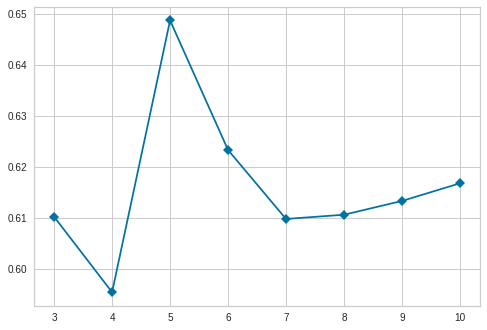

In [56]:
kclusters = (3,11)

jakarta_grouped_clustering = jakarta_grouped2.drop('Neighborhood', 1)

# run k-means clustering
model = KMeans(random_state=0)
visualizer = KElbowVisualizer(model, k=kclusters, metric='silhouette', timings=False) # random state = 0

visualizer.fit(jakarta_grouped_clustering)        # Fit the data to the visualizer
visualizer.show() 

In [57]:
# run k-means clustering
kclusters = 5
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(jakarta_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_

array([2, 0, 2, 3, 4, 1, 1, 4, 0, 3, 1, 1, 0, 4, 0, 1, 1, 0, 3, 1, 1, 3,
       0, 0, 0, 0, 0, 1, 3, 1, 3, 1, 0, 0, 0, 3, 0, 4, 3], dtype=int32)

In [59]:
# add clustering labels
# neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
neighborhoods_venues_sorted['Cluster Labels'] = pd.Series(kmeans.labels_)

df_merged = df

# merge boroughs_grouped with df to add latitude/longitude for each neighborhood
df_merged = df_merged.merge(neighborhoods_venues_sorted, left_on= 'neighborhood', right_on= 'Neighborhood')

df_merged

,lat,lng,borough,neighborhood,nama_kecamatan_x,child_population,nama_kecamatan_y,adult_population,nama_kecamatan_x,elder_population,nama_kecamatan_y,total_population,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster Labels
0,-6.334917,106.823737,JAKARTA SELATAN,JAGAKARSA,JAGAKARSA,92129,JAGAKARSA,145741,JAGAKARSA,26426,JAGAKARSA,363091,JAGAKARSA,Indonesian Restaurant,Asian Restaurant,Arcade,Wine Bar,Fast Food Restaurant,Cosmetics Shop,Cupcake Shop,Deli / Bodega,Department Store,Dessert Shop,1
1,-6.293981,106.823737,JAKARTA SELATAN,PASAR MINGGU,PASAR MINGGU,81159,PASAR MINGGU,131646,PASAR MINGGU,26774,PASAR MINGGU,331825,PASAR MINGGU,Convenience Store,Food Truck,Other Great Outdoors,Campground,Noodle House,Bus Line,Fast Food Restaurant,Food & Drink Shop,Soup Place,Gas Station,1
2,-6.284528,106.800140,JAKARTA SELATAN,CILANDAK,CILANDAK,51620,CILANDAK,87359,CILANDAK,20980,CILANDAK,225332,CILANDAK,Hobby Shop,Convenience Store,Hardware Store,Café,Food Truck,Wine Bar,Electronics Store,Cosmetics Shop,Cupcake Shop,Deli / Bodega,3
3,-6.247428,106.761798,JAKARTA SELATAN,PESANGGRAHAN,PESANGGRAHAN,65879,PESANGGRAHAN,105270,PESANGGRAHAN,21502,PESANGGRAHAN,264667,PESANGGRAHAN,Fast Food Restaurant,Coffee Shop,Boutique,Convenience Store,Cosmetics Shop,Cupcake Shop,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,3
4,-6.244392,106.776544,JAKARTA SELATAN,KEBAYORAN LAMA,KEBAYORAN LAMA,78496,KEBAYORAN LAMA,127936,KEBAYORAN LAMA,29058,KEBAYORAN LAMA,329442,KEBAYORAN LAMA,Golf Course,Wine Bar,Fast Food Restaurant,Convenience Store,Cosmetics Shop,Cupcake Shop,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,1
5,-6.243622,106.800140,JAKARTA SELATAN,KEBAYORAN BARU,KEBAYORAN BARU,34417,KEBAYORAN BARU,59832,KEBAYORAN BARU,16371,KEBAYORAN BARU,156737,KEBAYORAN BARU,Japanese Restaurant,Coffee Shop,Restaurant,Sushi Restaurant,Noodle House,Hotel,Food Truck,Korean Restaurant,Bakery,Bubble Tea Shop,0
6,-6.250614,106.820787,JAKARTA SELATAN,MAMPANG PRAPATAN,MAMPANG PRAPATAN,38087,MAMPANG PRAPATAN,62743,MAMPANG PRAPATAN,12634,MAMPANG PRAPATAN,159079,MAMPANG PRAPATAN,Fast Food Restaurant,Indonesian Restaurant,Wine Bar,Convenience Store,Cosmetics Shop,Cupcake Shop,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,0
7,-6.252300,106.847338,JAKARTA SELATAN,PANCORAN,PANCORAN,42794,PANCORAN,69126,PANCORAN,14762,PANCORAN,176719,PANCORAN,Convenience Store,Street Food Gathering,University,Food Court,Dim Sum Restaurant,Wine Bar,Dumpling Restaurant,Donut Shop,Diner,Department Store,0
8,-6.231860,106.847338,JAKARTA SELATAN,TEBET,TEBET,55974,TEBET,91987,TEBET,23950,TEBET,242259,TEBET,Indonesian Restaurant,Hotel,Pet Store,Park,Spa,Restaurant,Breakfast Spot,Salon / Barbershop,Deli / Bodega,Pharmacy,3
9,-6.219569,106.832587,JAKARTA SELATAN,SETIA BUDI,SETIA BUDI,26817,SETIA BUDI,45230,SETIA BUDI,11119,SETIA BUDI,117851,SETIA BUDI,Coffee Shop,Hotel,Café,Pizza Place,Soccer Field,Diner,Wine Bar,Building,Italian Restaurant,Fast Food Restaurant,0


In [60]:
df_merged = df_merged.drop(columns=['nama_kecamatan_x', 'nama_kecamatan_y'])

In [61]:
df_merged.groupby('Cluster Labels')['neighborhood'].count()

Cluster Labels
0    14
1    11
2     2
3     8
4     4
Name: neighborhood, dtype: int64

In [62]:
temp = df_merged[[column for column in df_merged.columns if (column.startswith('1st')) | (column.startswith('2')) | (column.startswith('3')) | (column=='Cluster Labels')]]
temp.head()

,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,Cluster Labels
0,Indonesian Restaurant,Asian Restaurant,Arcade,1
1,Convenience Store,Food Truck,Other Great Outdoors,1
2,Hobby Shop,Convenience Store,Hardware Store,3
3,Fast Food Restaurant,Coffee Shop,Boutique,3
4,Golf Course,Wine Bar,Fast Food Restaurant,1


### Visualize the clusters

In [63]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(df_merged['lat'], df_merged['lng'], df_merged['neighborhood'], df_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=7,
        popup=label,
        color='black',
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.9).add_to(map_clusters)
       
map_clusters

### Cluster 1

In [99]:
cluster_0 = df_merged.loc[df_merged['Cluster Labels'] == 0]
cluster_0

,lat,lng,borough,neighborhood,child_population,adult_population,elder_population,total_population,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster Labels
5,-6.243622,106.800140,JAKARTA SELATAN,KEBAYORAN BARU,34417,59832,16371,156737,KEBAYORAN BARU,Japanese Restaurant,Coffee Shop,Restaurant,Sushi Restaurant,Noodle House,Hotel,Food Truck,Korean Restaurant,Bakery,Bubble Tea Shop,0
6,-6.250614,106.820787,JAKARTA SELATAN,MAMPANG PRAPATAN,38087,62743,12634,159079,MAMPANG PRAPATAN,Fast Food Restaurant,Indonesian Restaurant,Wine Bar,Convenience Store,Cosmetics Shop,Cupcake Shop,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,0
7,-6.252300,106.847338,JAKARTA SELATAN,PANCORAN,42794,69126,14762,176719,PANCORAN,Convenience Store,Street Food Gathering,University,Food Court,Dim Sum Restaurant,Wine Bar,Dumpling Restaurant,Donut Shop,Diner,Department Store,0
9,-6.219569,106.832587,JAKARTA SELATAN,SETIA BUDI,26817,45230,11119,117851,SETIA BUDI,Coffee Shop,Hotel,Café,Pizza Place,Soccer Field,Diner,Wine Bar,Building,Italian Restaurant,Fast Food Restaurant,0
18,-6.203285,106.862089,JAKARTA TIMUR,MATRAMAN,43897,73373,18662,191134,MATRAMAN,Pharmacy,Fast Food Restaurant,Pizza Place,Hardware Store,Dumpling Restaurant,Coffee Shop,Concert Hall,Convenience Store,Cosmetics Shop,Cupcake Shop,0
19,-6.202362,106.811938,JAKARTA PUSAT,TANAH ABANG,42768,71114,17812,181496,TANAH ABANG,Seafood Restaurant,Food Truck,Pizza Place,Arcade,Nightclub,Indonesian Restaurant,Fast Food Restaurant,Javanese Restaurant,Restaurant,Diner,0
20,-6.194031,106.832587,JAKARTA PUSAT,MENTENG,19861,35348,11049,92066,MENTENG,Indonesian Restaurant,Park,Chinese Restaurant,Dessert Shop,Lake,Café,Electronics Store,Soup Place,Hotel Bar,Betawinese Restaurant,0
21,-6.183054,106.856188,JAKARTA PUSAT,JOHAR BARU,34716,57775,13776,146160,JOHAR BARU,Fast Food Restaurant,Convenience Store,Arcade,Food Truck,Wine Bar,Cosmetics Shop,Cupcake Shop,Deli / Bodega,Department Store,Dessert Shop,0
22,-6.182671,106.867990,JAKARTA PUSAT,CEMPAKA PUTIH,22418,38744,11099,102273,CEMPAKA PUTIH,Pizza Place,Acehnese Restaurant,Furniture / Home Store,Middle Eastern Restaurant,Food Truck,BBQ Joint,Pool,Indonesian Meatball Place,Cosmetics Shop,Cupcake Shop,0
24,-6.153194,106.832587,JAKARTA PUSAT,SAWAH BESAR,27475,50533,17575,133550,SAWAH BESAR,Convenience Store,Pet Store,Hotel,Karaoke Bar,Camera Store,Noodle House,Fast Food Restaurant,Indonesian Restaurant,Gas Station,Diner,0


In [100]:
first = cluster_0.groupby('1st Most Common Venue').count().sort_values(by='Neighborhood', ascending=False).reset_index()
first= first[['1st Most Common Venue', 'Neighborhood']]
first.rename(columns={'1st Most Common Venue':'Venue'}, inplace=True)
first


,Venue,Neighborhood
0,Convenience Store,2
1,Fast Food Restaurant,2
2,Indonesian Restaurant,2
3,Bookstore,1
4,Coffee Shop,1
5,Japanese Restaurant,1
6,Noodle House,1
7,Palace,1
8,Pharmacy,1
9,Pizza Place,1


In [101]:
second = cluster_0.groupby('2nd Most Common Venue').count().sort_values(by='Neighborhood', ascending=False).reset_index()
second= second[['2nd Most Common Venue', 'Neighborhood']]
second.rename(columns={'2nd Most Common Venue':'Venue'}, inplace=True)
second

,Venue,Neighborhood
0,Acehnese Restaurant,1
1,Arts & Crafts Store,1
2,Asian Restaurant,1
3,Chinese Restaurant,1
4,Coffee Shop,1
5,Convenience Store,1
6,Fast Food Restaurant,1
7,Food Court,1
8,Food Truck,1
9,Hotel,1


In [102]:
third = cluster_0.groupby('3rd Most Common Venue').count().sort_values(by='Neighborhood', ascending=False).reset_index()
third= third[['3rd Most Common Venue', 'Neighborhood']]
third.rename(columns={'3rd Most Common Venue':'Venue'}, inplace=True)
third

,Venue,Neighborhood
0,Pizza Place,2
1,Arcade,1
2,BBQ Joint,1
3,Café,1
4,Chinese Restaurant,1
5,Furniture / Home Store,1
6,Hotel,1
7,Kids Store,1
8,Movie Theater,1
9,Restaurant,1


In [103]:
cluster_0_top3 = pd.concat([first, second, third])
cluster_0_top3 = cluster_0_top3.groupby(by='Venue').sum().sort_values(by='Neighborhood', ascending=False)
cluster_0_top3

,Neighborhood
Venue,
Indonesian Restaurant,3
Pizza Place,3
Fast Food Restaurant,3
Convenience Store,3
Hotel,2
Chinese Restaurant,2
Coffee Shop,2
Seafood Restaurant,2
Restaurant,1


### Cluster 2


In [93]:
cluster_1 = df_merged.loc[df_merged['Cluster Labels'] == 1]
cluster_1

,lat,lng,borough,neighborhood,child_population,adult_population,elder_population,total_population,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster Labels
0,-6.334917,106.823737,JAKARTA SELATAN,JAGAKARSA,92129,145741,26426,363091,JAGAKARSA,Indonesian Restaurant,Asian Restaurant,Arcade,Wine Bar,Fast Food Restaurant,Cosmetics Shop,Cupcake Shop,Deli / Bodega,Department Store,Dessert Shop,1
1,-6.293981,106.823737,JAKARTA SELATAN,PASAR MINGGU,81159,131646,26774,331825,PASAR MINGGU,Convenience Store,Food Truck,Other Great Outdoors,Campground,Noodle House,Bus Line,Fast Food Restaurant,Food & Drink Shop,Soup Place,Gas Station,1
4,-6.244392,106.776544,JAKARTA SELATAN,KEBAYORAN LAMA,78496,127936,29058,329442,KEBAYORAN LAMA,Golf Course,Wine Bar,Fast Food Restaurant,Convenience Store,Cosmetics Shop,Cupcake Shop,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,1
11,-6.323116,106.870940,JAKARTA TIMUR,CIRACAS,79916,128816,24553,316639,CIRACAS,Pet Store,Farmers Market,Concert Hall,Convenience Store,Cosmetics Shop,Cupcake Shop,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,1
12,-6.327251,106.900447,JAKARTA TIMUR,CIPAYUNG,74479,119613,20401,291416,CIPAYUNG,Asian Restaurant,Food Truck,Wine Bar,Fast Food Restaurant,Convenience Store,Cosmetics Shop,Cupcake Shop,Deli / Bodega,Department Store,Dessert Shop,1
14,-6.230702,106.882743,JAKARTA TIMUR,JATINEGARA,79079,128767,30584,328292,JATINEGARA,Farmers Market,Indonesian Restaurant,Donut Shop,Coffee Shop,Wine Bar,Convenience Store,Cosmetics Shop,Cupcake Shop,Deli / Bodega,Department Store,1
17,-6.181712,106.897496,JAKARTA TIMUR,PULO GADUNG,72037,119477,29164,309558,PULO GADUNG,Convenience Store,Wine Bar,Fast Food Restaurant,Cosmetics Shop,Cupcake Shop,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,1
26,-6.191233,106.742319,JAKARTA BARAT,KEMBANGAN,76517,122771,25313,304815,KEMBANGAN,Japanese Restaurant,Café,Asian Restaurant,Residential Building (Apartment / Condo),Coffee Shop,Clothing Store,Department Store,Bubble Tea Shop,Korean Restaurant,Electronics Store,1
27,-6.195942,106.773595,JAKARTA BARAT,KEBON JERUK,89005,144391,32187,362899,KEBON JERUK,Concert Hall,Park,Asian Restaurant,Food Truck,Farmers Market,Convenience Store,Cosmetics Shop,Cupcake Shop,Deli / Bodega,Department Store,1
33,-6.126742,106.782443,JAKARTA UTARA,PENJARINGAN,77109,128210,31152,321540,PENJARINGAN,Chinese Restaurant,Electronics Store,Fast Food Restaurant,Pizza Place,Food Truck,Café,Massage Studio,Seafood Restaurant,Bookstore,Basketball Stadium,1


In [94]:
first = cluster_1.groupby('1st Most Common Venue').count().sort_values(by='Neighborhood', ascending=False).reset_index()
first= first[['1st Most Common Venue', 'Neighborhood']]
first.rename(columns={'1st Most Common Venue':'Venue'}, inplace=True)
first

,Venue,Neighborhood
0,Convenience Store,2
1,Indonesian Restaurant,2
2,Asian Restaurant,1
3,Chinese Restaurant,1
4,Concert Hall,1
5,Farmers Market,1
6,Golf Course,1
7,Japanese Restaurant,1
8,Pet Store,1


In [95]:
second = cluster_1.groupby('2nd Most Common Venue').count().sort_values(by='Neighborhood', ascending=False).reset_index()
second= second[['2nd Most Common Venue', 'Neighborhood']]
second.rename(columns={'2nd Most Common Venue':'Venue'}, inplace=True)
second

,Venue,Neighborhood
0,Café,2
1,Food Truck,2
2,Wine Bar,2
3,Asian Restaurant,1
4,Electronics Store,1
5,Farmers Market,1
6,Indonesian Restaurant,1
7,Park,1


In [96]:
third = cluster_1.groupby('3rd Most Common Venue').count().sort_values(by='Neighborhood', ascending=False).reset_index()
third= third[['3rd Most Common Venue', 'Neighborhood']]
third.rename(columns={'3rd Most Common Venue':'Venue'}, inplace=True)
third

,Venue,Neighborhood
0,Fast Food Restaurant,3
1,Asian Restaurant,2
2,Arcade,1
3,Concert Hall,1
4,Donut Shop,1
5,Other Great Outdoors,1
6,Tennis Stadium,1
7,Wine Bar,1


In [97]:
cluster_1_top3 = pd.concat([first, second, third])
cluster_1_top3 = cluster_1_top3.groupby(by='Venue').sum().sort_values(by='Neighborhood', ascending=False)
cluster_1_top3

,Neighborhood
Venue,
Asian Restaurant,4
Fast Food Restaurant,3
Indonesian Restaurant,3
Wine Bar,3
Concert Hall,2
Convenience Store,2
Farmers Market,2
Food Truck,2
Café,2


### Cluster 3


In [104]:
cluster_2 = df_merged.loc[df_merged['Cluster Labels'] == 2]
cluster_2

,lat,lng,borough,neighborhood,child_population,adult_population,elder_population,total_population,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster Labels
16,-6.182629,106.947666,JAKARTA TIMUR,CAKUNG,151969,236707,35626,572996,CAKUNG,Soccer Stadium,Gas Station,Seafood Restaurant,Lounge,Supermarket,Coffee Shop,Gastropub,Furniture / Home Store,Concert Hall,Convenience Store,2
31,-6.148665,106.735258,JAKARTA BARAT,CENGKARENG,149328,237620,37949,576216,CENGKARENG,Hotel,Pet Store,Department Store,Music Venue,Movie Theater,Convenience Store,Cosmetics Shop,Cupcake Shop,Deli / Bodega,Dessert Shop,2


In [105]:
first = cluster_2.groupby('1st Most Common Venue').count().sort_values(by='Neighborhood', ascending=False).reset_index()
first= first[['1st Most Common Venue', 'Neighborhood']]
first.rename(columns={'1st Most Common Venue':'Venue'}, inplace=True)
first

,Venue,Neighborhood
0,Hotel,1
1,Soccer Stadium,1


In [106]:
second = cluster_2.groupby('2nd Most Common Venue').count().sort_values(by='Neighborhood', ascending=False).reset_index()
second= second[['2nd Most Common Venue', 'Neighborhood']]
second.rename(columns={'2nd Most Common Venue':'Venue'}, inplace=True)
second

,Venue,Neighborhood
0,Gas Station,1
1,Pet Store,1


In [107]:
third = cluster_2.groupby('3rd Most Common Venue').count().sort_values(by='Neighborhood', ascending=False).reset_index()
third= third[['3rd Most Common Venue', 'Neighborhood']]
third.rename(columns={'3rd Most Common Venue':'Venue'}, inplace=True)
third

,Venue,Neighborhood
0,Department Store,1
1,Seafood Restaurant,1


In [108]:
cluster_2_top3 = pd.concat([first, second, third])
cluster_2_top3 = cluster_2_top3.groupby(by='Venue').sum().sort_values(by='Neighborhood', ascending=False)
cluster_2_top3.head()

,Neighborhood
Venue,
Department Store,1
Gas Station,1
Hotel,1
Pet Store,1
Seafood Restaurant,1


### Cluster 4

In [109]:
cluster_3 = df_merged.loc[df_merged['Cluster Labels'] == 3]
cluster_3

,lat,lng,borough,neighborhood,child_population,adult_population,elder_population,total_population,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster Labels
2,-6.284528,106.800140,JAKARTA SELATAN,CILANDAK,51620,87359,20980,225332,CILANDAK,Hobby Shop,Convenience Store,Hardware Store,Café,Food Truck,Wine Bar,Electronics Store,Cosmetics Shop,Cupcake Shop,Deli / Bodega,3
3,-6.247428,106.761798,JAKARTA SELATAN,PESANGGRAHAN,65879,105270,21502,264667,PESANGGRAHAN,Fast Food Restaurant,Coffee Shop,Boutique,Convenience Store,Cosmetics Shop,Cupcake Shop,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,3
8,-6.231860,106.847338,JAKARTA SELATAN,TEBET,55974,91987,23950,242259,TEBET,Indonesian Restaurant,Hotel,Pet Store,Park,Spa,Restaurant,Breakfast Spot,Salon / Barbershop,Deli / Bodega,Pharmacy,3
10,-6.326164,106.856188,JAKARTA TIMUR,PASAR REBO,59352,96232,17477,235073,PASAR REBO,Convenience Store,Wine Bar,Fast Food Restaurant,Cosmetics Shop,Cupcake Shop,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,3
13,-6.271194,106.894546,JAKARTA TIMUR,MAKASAR,55450,89762,17748,224449,MAKASAR,Airport Terminal,Wine Bar,Fast Food Restaurant,Convenience Store,Cosmetics Shop,Cupcake Shop,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,3
23,-6.160372,106.847338,JAKARTA PUSAT,KEMAYORAN,62798,104021,25321,266309,KEMAYORAN,Asian Restaurant,Convenience Store,Boarding House,Dumpling Restaurant,Food Court,Food Truck,Dessert Shop,Sundanese Restaurant,Indonesian Restaurant,Hotel,3
28,-6.162275,106.788342,JAKARTA BARAT,GROGOL PETAMBURAN,53038,91415,27264,240015,GROGOL PETAMBURAN,Noodle House,Indonesian Restaurant,Chinese Restaurant,Asian Restaurant,Fried Chicken Joint,Fast Food Restaurant,Snack Place,Hotel,Train Station,Arts & Crafts Store,3
29,-6.149040,106.803089,JAKARTA BARAT,TAMBORA,63455,108787,26510,273331,TAMBORA,Chinese Restaurant,Fast Food Restaurant,Asian Restaurant,Food Truck,Noodle House,Department Store,Breakfast Spot,Food Court,Convenience Store,Furniture / Home Store,3


In [110]:
first = cluster_3.groupby('1st Most Common Venue').count().sort_values(by='Neighborhood', ascending=False).reset_index()
first= first[['1st Most Common Venue', 'Neighborhood']]
first.rename(columns={'1st Most Common Venue':'Venue'}, inplace=True)
first

,Venue,Neighborhood
0,Airport Terminal,1
1,Asian Restaurant,1
2,Chinese Restaurant,1
3,Convenience Store,1
4,Fast Food Restaurant,1
5,Hobby Shop,1
6,Indonesian Restaurant,1
7,Noodle House,1


In [111]:
second = cluster_3.groupby('2nd Most Common Venue').count().sort_values(by='Neighborhood', ascending=False).reset_index()
second= second[['2nd Most Common Venue', 'Neighborhood']]
second.rename(columns={'2nd Most Common Venue':'Venue'}, inplace=True)
second

,Venue,Neighborhood
0,Convenience Store,2
1,Wine Bar,2
2,Coffee Shop,1
3,Fast Food Restaurant,1
4,Hotel,1
5,Indonesian Restaurant,1


In [112]:
third = cluster_3.groupby('3rd Most Common Venue').count().sort_values(by='Neighborhood', ascending=False).reset_index()
third= third[['3rd Most Common Venue', 'Neighborhood']]
third.rename(columns={'3rd Most Common Venue':'Venue'}, inplace=True)
third

,Venue,Neighborhood
0,Fast Food Restaurant,2
1,Asian Restaurant,1
2,Boarding House,1
3,Boutique,1
4,Chinese Restaurant,1
5,Hardware Store,1
6,Pet Store,1


In [113]:
cluster_3_top3 = pd.concat([first, second, third])
cluster_3_top3 = cluster_3_top3.groupby(by='Venue').sum().sort_values(by='Neighborhood', ascending=False)
cluster_3_top3.head()

,Neighborhood
Venue,
Fast Food Restaurant,4
Convenience Store,3
Asian Restaurant,2
Chinese Restaurant,2
Indonesian Restaurant,2


### Cluster 5


In [84]:
cluster_4 = df_merged.loc[df_merged['Cluster Labels'] == 4]
cluster_4

,lat,lng,borough,neighborhood,child_population,adult_population,elder_population,total_population,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster Labels
15,-6.229541,106.918153,JAKARTA TIMUR,DUREN SAWIT,109611,174633,41431,446773,DUREN SAWIT,River,Indonesian Meatball Place,Indonesian Restaurant,Food Truck,Burger Joint,Wine Bar,Donut Shop,Diner,Dim Sum Restaurant,Department Store,4
32,-6.134294,106.705773,JAKARTA BARAT,KALI DERES,117088,188680,26424,449946,KALI DERES,Noodle House,Fast Food Restaurant,Food Court,Fried Chicken Joint,Supermarket,Indonesian Restaurant,Convenience Store,Cupcake Shop,Deli / Bodega,Electronics Store,4
35,-6.132055,106.871485,JAKARTA UTARA,TANJUNG PRIOK,104531,167125,34368,419555,TANJUNG PRIOK,Pizza Place,Food Truck,Lake,Fast Food Restaurant,Gym,Golf Course,Concert Hall,Convenience Store,Cosmetics Shop,Cupcake Shop,4
38,-6.121428,106.947666,JAKARTA UTARA,CILINCING,121877,182346,26305,440235,CILINCING,BBQ Joint,Wine Bar,Fast Food Restaurant,Convenience Store,Cosmetics Shop,Cupcake Shop,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,4


In [85]:
first = cluster_4.groupby('1st Most Common Venue').count().sort_values(by='Neighborhood', ascending=False).reset_index()
first= first[['1st Most Common Venue', 'Neighborhood']]
first.rename(columns={'1st Most Common Venue':'Venue'}, inplace=True)
first

,Venue,Neighborhood
0,BBQ Joint,1
1,Noodle House,1
2,Pizza Place,1
3,River,1


In [86]:
second = cluster_4.groupby('2nd Most Common Venue').count().sort_values(by='Neighborhood', ascending=False).reset_index()
second= second[['2nd Most Common Venue', 'Neighborhood']]
second.rename(columns={'2nd Most Common Venue':'Venue'}, inplace=True)
second

,Venue,Neighborhood
0,Fast Food Restaurant,1
1,Food Truck,1
2,Indonesian Meatball Place,1
3,Wine Bar,1


In [87]:
third = cluster_4.groupby('3rd Most Common Venue').count().sort_values(by='Neighborhood', ascending=False).reset_index()
third= third[['3rd Most Common Venue', 'Neighborhood']]
third.rename(columns={'3rd Most Common Venue':'Venue'}, inplace=True)
third

,Venue,Neighborhood
0,Fast Food Restaurant,1
1,Food Court,1
2,Indonesian Restaurant,1
3,Lake,1


In [89]:
cluster_4_top3 = pd.concat([first, second, third])
cluster_4_top3 = cluster_4_top3.groupby(by='Venue').sum().sort_values(by='Neighborhood', ascending=False)
cluster_4_top3

,Neighborhood
Venue,
Fast Food Restaurant,2
BBQ Joint,1
Food Court,1
Food Truck,1
Indonesian Meatball Place,1
Indonesian Restaurant,1
Lake,1
Noodle House,1
Pizza Place,1


## Results and Discussion <a name="results"></a>

As a result, we can group the neighborhoods in DKI Jakarta province into 5 clusters.


*   Cluster 1: This cluster has quite a number of culinary tourism destinations. In addition, there are not many coffee shops or cafes that have opened their business in this cluster. However, the number of adult population in this cluster tends to be low.

*   Cluster 2: Similar to the first cluster. Culinary tourism in this cluster has developed well and there are not many competitors in the coffee shop or cafe sector. Unlike the first cluster, there are more adult population in this cluster.

*   Cluster 3: The neighborhood in this cluster has the most adult population among other clusters. However, the location of the two neighborhoods is quite far from the city center so that the accessibility for this cluster is not good. Not only that, there are only a few culinary destinations available in this cluster, making this cluster not the first choice when someone wants to have a culinary tour.


*   Cluster 4: This cluster has a character similar to cluster 1, there are many culinary tourism destinations. However, there are not many adult population in this cluster. And unlike cluster 1 which tends to be in the middle of the city, cluster 4 is located slightly on the outskirts of the city.

*   Cluster 5: Similar to cluster 3. However, the potential in this cluster looks a little better because there are already several culinary tourism destinations available.


The main objective of this project is to find the best location to open a new cafe in Jakarta. There are many parameters that can be used to assess each location. but here we look at the demographics and businesses situation.



1.   Demographics: The most important thing in a culinary business is the customer. No matter how delicious our menu is, it's meaningless if we don't have customers. Therefore, in this project we are looking for a location where our target market is located.

2.   Businesses situation: 

*   The business situation of a region can play a positive role.
*   Cluster 3 as an example, although there are many target markets there, the cluster does not attract foodies to come to the cluster. This makes it quite difficult for a businessperson to be able to continue to grow his business. Because of that, we consider this cluster is not recommended.

*   Cluster 2 to be precise at Jagaraksa, is our top choice for our business location. This is based on the consideration of the attractiveness of approaching the neighborhood because culinary tourism there has been well developed, besides that Jagaraksa also has the 7th largest adult population in Jakarta with 363,000 people.





## Conclusion <a name="conclusion"></a>

Finding the best location to open a business is not an easy matter, there are lots of uncertainties. It takes deep and mature consideration to be able to find the best location. Fortunately, with the available data, we can get very valuable insights, which may not be obtained just by surveying the location. This can greatly help everyone to make more informed decisions.

Using this project as an example, I hope it will inspire everyone to deal with a similar case in the future. I would be very happy if any of you wanted to have a discussion!